In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob

In [7]:
# Functions for displaying images
%matplotlib inline

def show_image (image, isgray=False):
    plt.figure ()
    plt.imshow (image, cmap='gray')
    plt.show ()

def plt_show (image):
    plt.figure ()
    plt.imshow (image)
    plt.show ()
    
def show_images_grid (images, grid_size, fig_size = (10, 10), cmap=None, titles=None):
    x, y = grid_size
    fig, imtable = plt.subplots (y, x, figsize = fig_size, squeeze=False)
    for j in range (y):
        for i in range (x):
            im_idx = i + j*x
            if (isinstance(cmap, (list, tuple))):
                imtable [j][i].imshow (images[im_idx], cmap=cmap[i])
            else:
                image = images[im_idx]
                if len(image.shape) == 3:
                    imtable [j][i].imshow (image)
                else:
                    imtable [j][i].imshow (image, cmap='gray')
            imtable [j][i].axis('off')
    plt.show ()

8792 vehicles
8968 non-vehicles


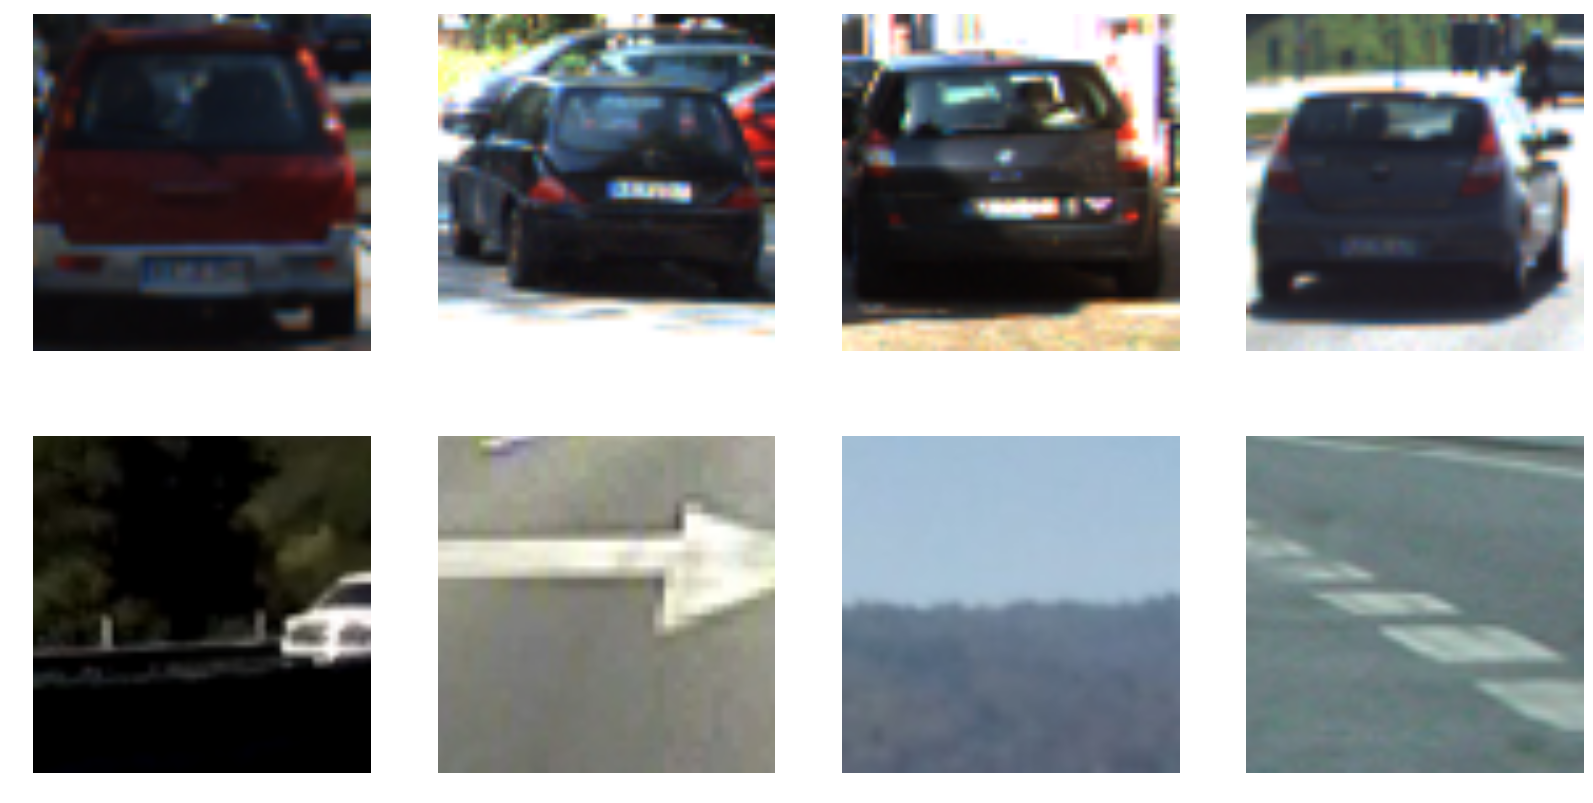

In [9]:
import random

# Download training data from 
# https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/vehicles.zip
# and place in dataset/vehicles

# Download training data from
# https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/non-vehicles.zip
# and place in dataset/nonvehicles

vehicle_image_names = glob.glob('dataset/vehicles/**/*.png', recursive=True)
non_vehicle_image_names = glob.glob('dataset/non-vehicles/**/*.png', recursive=True)

vehicle_images = [mpimg.imread(vehicle_image_name) for vehicle_image_name in vehicle_image_names]

non_vehicle_images = [mpimg.imread(non_vehicle_image_name) for non_vehicle_image_name in non_vehicle_image_names]

print(len(vehicle_images), 'vehicles')
print(len(non_vehicle_images), 'non-vehicles')

# show dataset images examples
example_images = [
    random.choice(vehicle_images),
    random.choice(vehicle_images),
    random.choice(vehicle_images),
    random.choice(vehicle_images),
    random.choice(non_vehicle_images),
    random.choice(non_vehicle_images),
    random.choice(non_vehicle_images),
    random.choice(non_vehicle_images),
]

show_images_grid (example_images, (4, 2), fig_size=(20, 10))

In [22]:
import csv
import random as rand
from multiprocessing import Pool

num_vehicle_examples = 10000
num_non_vehicle_examples = 40000
images_data = {}
num_cars = 0

# Get more pictures from autti dataset
labels_file = 'dataset/autti/labels.csv'

# Get data from csv file
with open(labels_file, newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=' ', quotechar='|')
    for line in reader:
        image_name = line [0]
        if image_name in images_data:
            image = images_data [image_name]
        else:
            image = {
                'image_name' : 'dataset/autti/' + image_name,
                'boxes' : []  # Empty list to put boxes lates
            }
            images_data [image_name] = image
            
            
        if (line[6] == '"car"'):
            box_data = {
                'x1' : int(line [1]),
                'y1' : int(line [2]),
                'x2' : int(line [3]),
                'y2' : int(line [4])
            }
            image ['boxes'].append (box_data)
            num_cars += 1

print ('autti images:', len (images_data))
print ('cars:', num_cars)


def is_intersect (box, boxes):
    """Check if box have intersection with other boxes
    Args:
        box (dict): box coords as
            {
                'x1' : int, # top left coords
                'y1' : int,
                'x2' : int, # bottom right coords
                'y2' : int
            }
        boxes (list): list of other boxes
    Returns:
        boolean: True if box has intersection with boxes, False otherwise
    """
    x1, x2, y1, y2 = box ['x1'], box ['x2'], box ['y1'], box ['y2']
    for b in boxes:
        bx1, bx2, by1, by2 = b ['x1'], b ['x2'], b ['y1'], b ['y2']
        return ((((x1 >= bx1 and x1 <= bx2) or 
                  (x2 >= bx1 and x2 <= bx2)) and
                 ((y1 >= by1 and y1 <= by2) or 
                  (y2 >= by1 and y2 <= by2))) or
                (((bx1 >= x1 and bx1 <= x2) or 
                  (bx2 >= x1 and bx2 <= x2)) and
                 ((by1 >= y1 and by1 <= y2) or 
                  (by2 >= y1 and by2 <= y2))))

generated_box_size = [128, 64, 48]
def generate_non_vehicle_box (size, vehicle_boxes):
    """
    Generates a box without a vehicle in it
    """
    while True:
        box_size = [generated_box_size [rand.randint (0, len(generated_box_size) - 1)]] * 2
        available_poss = [
            size[0] - box_size[0],
            size[1] - box_size[1],
            ]
        pos = [
            rand.randint (0, available_poss[0] - 1),
            rand.randint (0, available_poss[1] - 1)
            ]
        box = {
            'x1': pos [0],
            'y1': pos [1],
            'x2': pos [0] + box_size [0],
            'y2': pos [1] + box_size [1]
        }
        if not is_intersect (box, vehicle_boxes):
            return box
    

images_last_index = len (images_data) - 1
keys = list(images_data.keys())

# Augment all images in parallel

def augment_image(i):
    augmented_car = None
    augmented_notcar = None
    
    
    # Pick a random image
    image_data = images_data [keys[rand.randint (0, images_last_index)]]
    # Skip if car doesn't exist
    if len(image_data ['boxes']) == 0:
        return augmented_car, augmented_notcar
        
    vehicle_box = image_data['boxes'][rand.randint(0, len(image_data['boxes']))-1]

    im = mpimg.imread(image_data ['image_name'])
    im = im.astype(np.float32)/255

    #get car from image
    if i < num_vehicle_examples:
        augmented_car = im[vehicle_box['y1']:vehicle_box['y2'], vehicle_box['x1']:vehicle_box['x2']]
        augmented_car = cv2.resize(augmented_car, (64, 64), interpolation=cv2.INTER_AREA)

    #get not car from image
    if i < num_non_vehicle_examples:
        notcarbox = generate_non_vehicle_box ([im.shape[1], im.shape[0]], image_data['boxes'])
        augmented_notcar = im[notcarbox['y1']:notcarbox['y2'], notcarbox['x1']:notcarbox['x2']]
        augmented_notcar = cv2.resize(augmented_notcar, (64, 64), interpolation=cv2.INTER_AREA)
        
    return augmented_car, augmented_notcar

p = Pool()
# Generator for augmented data
augmented_data = p.imap_unordered(augment_image, range (max (num_vehicle_examples, num_non_vehicle_examples)))
augmented_cars = []
augmented_notcars = []
i = 0

for augmented_car, augmented_notcar in augmented_data:
    i+= 1
    if augmented_car is not None:
        augmented_cars.append(augmented_car)
    if augmented_notcar is not None:
        augmented_notcars.append(augmented_notcar)
        
    if i % 1000 == 0:
        print ('augmented:', i)

    

# this step takes about 40 mins
print ('augmented cars:', len (augmented_cars))
print ('augmented not cars:', len (augmented_notcars))


autti images: 13063
cars: 60788
augmented: 1000
augmented: 2000
augmented: 3000
augmented: 4000
augmented: 5000
augmented: 6000
augmented: 7000
augmented: 8000
augmented: 9000
augmented: 10000
augmented: 11000
augmented: 12000
augmented: 13000
augmented: 14000
augmented: 15000
augmented: 16000
augmented: 17000
augmented: 18000
augmented: 19000
augmented: 20000
augmented: 21000
augmented: 22000
augmented: 23000
augmented: 24000
augmented: 25000
augmented: 26000
augmented: 27000
augmented: 28000
augmented: 29000
augmented: 30000
augmented: 31000
augmented: 32000
augmented: 33000
augmented: 34000
augmented: 35000
augmented: 36000
augmented: 37000
augmented: 38000
augmented: 39000
augmented: 40000
augmented cars: 9788
augmented not cars: 39215


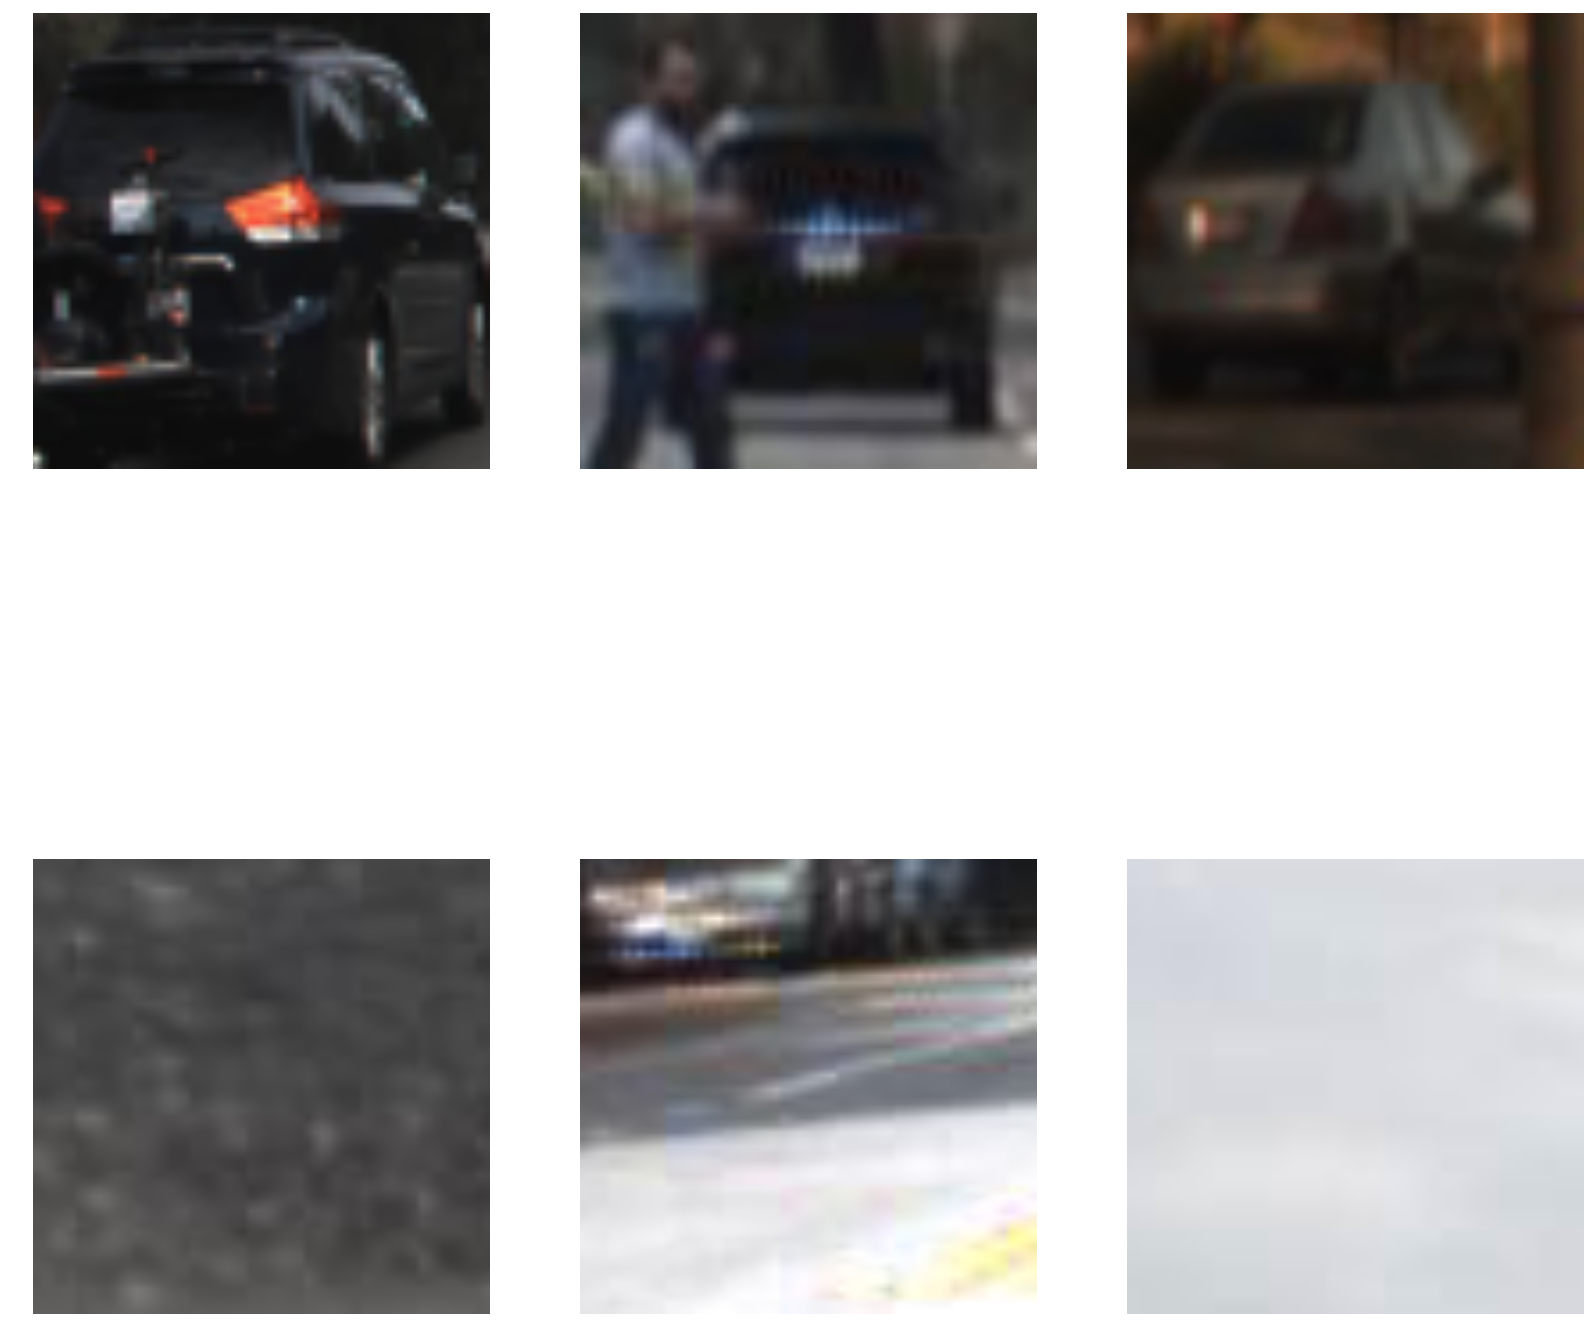

In [24]:
# show some samples generated from autti dataset
example_images = [augmented_cars [random.randint (0, len (augmented_cars)-1)] for i in range(3)] + \
                 [augmented_notcars [random.randint (0, len (augmented_notcars)-1)] for i in range(3)]

show_images_grid (example_images, (3, 2), fig_size=(20, 20))

In [31]:
from skimage.feature import hog
import math

# These functions are borrowed from udacity

# Define a function to return HOG features and visualization
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=False)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec)
        return features

def bin_spatial(img, size=(32, 32)):
    features = np.concatenate([cv2.resize(img[:,:,i], size).ravel() for i in range(3)])
    # Return the feature vector
    return features

def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the RGB channels separately
    rhist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    ghist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    bhist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Generating bin centers
    bin_edges = rhist[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

def saturation (img):
    hls = cv2.cvtColor (img, cv2.COLOR_BGR2HLS)
    return hls [:,:,2]

def extract_features(image, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        extract_spatial=True, extract_hist=True, extract_hog=True):
    # Create a list to append feature vectors to
    features = []
    # apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        feature_image = cv2.cvtColor (image, getattr(cv2, 'COLOR_RGB2' + color_space))
    else: feature_image = np.copy(image)      

    if extract_spatial:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        features.append(spatial_features)
        
    if extract_hist:
        # Apply color_hist()
        hist_features = color_hist(feature_image, nbins=hist_bins)
        features.append(hist_features)
        
    if extract_hog:
        
        if color_space == 'GRAY':
            hog_features = get_hog_features(feature_image, orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            
        elif hog_channel == 'ALL':
            hog_features = [get_hog_features(feature_image[:,:,i], 
                                             orient, pix_per_cell, 
                                             cell_per_block, 
                                             vis=False, feature_vec=True)
                            for i in range(3)]
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(hog_features)
        
    return np.concatenate(features)

def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    imgsizey = img.shape [0]
    imgsizex = img.shape [1]
    x_start_stop [0] = 0 if x_start_stop [0] is None else x_start_stop [0]
    x_start_stop [1] = imgsizex if x_start_stop [1] is None else x_start_stop [1]
    y_start_stop [0] = 0 if y_start_stop [0] is None else y_start_stop [0]
    y_start_stop [1] = imgsizey if y_start_stop [1] is None else y_start_stop [1]
    # Compute the span of the region to be searched
    sizex = x_start_stop [1] - x_start_stop [0]
    sizey = y_start_stop [1] - y_start_stop [0]
    # Compute the number of pixels per step in x/y
    stepx = int (xy_window [0] * xy_overlap [0])
    stepy = int (xy_window [1] * xy_overlap [1])
    # Compute the number of windows in x/y
    step_count_x = int (math.floor(1.0 * sizex / stepx)) - 1
    step_count_y = int (math.floor(1.0 * sizey / stepy)) - 1
    # Initialize a list to append window positions to
    window_list = []
    for i in range (step_count_y):
        for j in range (step_count_x):
            # Calculate each window position
            # Append window position to list
            window_list.append ((
                (x_start_stop [0] + j*stepx, y_start_stop [0] + i*stepy),
                (x_start_stop [0] + j*stepx + xy_window [0], y_start_stop [0] + i*stepy + xy_window [1])
                ))
    # Return the list of windows
    return window_list

def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy



In [32]:
# parameters of feature extraction

color_space = 'GRAY' # Can be GRAY, RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 8  # HOG orientations
pix_per_cell = 16 # HOG pixels per cell
cell_per_block = 1 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
extract_spatial = False # Spatial features on or off
extract_hist = False # Histogram features on or off
extract_hog = True # HOG features on or off


0


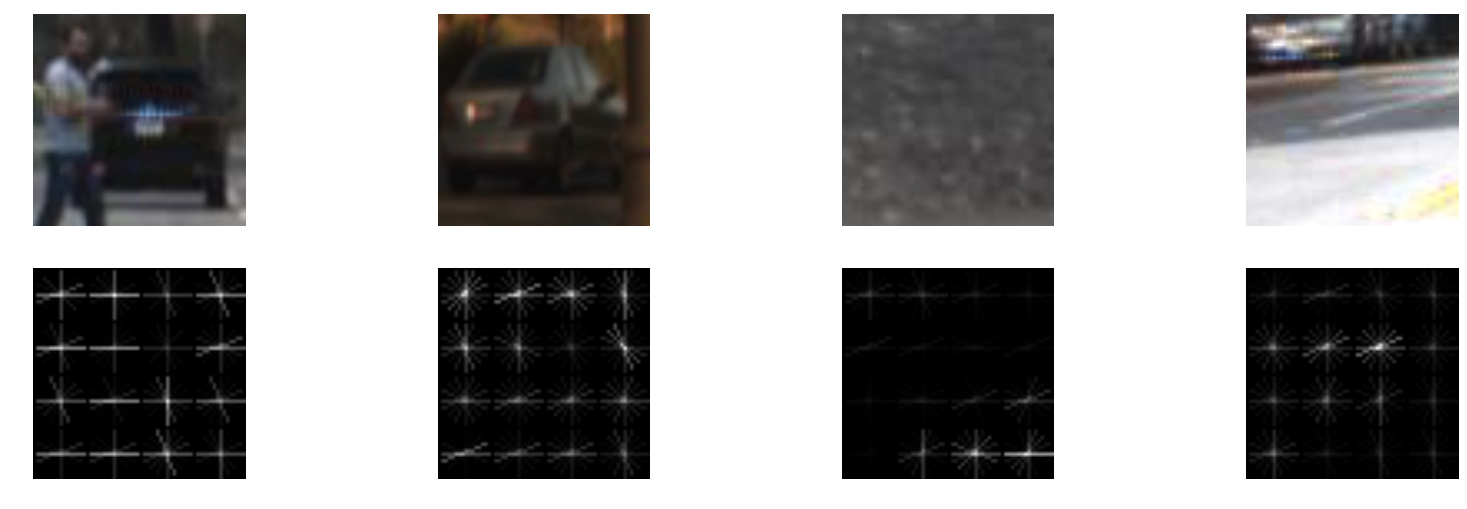

In [35]:
feature_examples = []
feature_examples.extend (images_for_features)

def f(image):
    return get_hog_features(saturation(image), orient, pix_per_cell, cell_per_block, vis=True)
    
p = Pool()
i = 0

for features, hog_image in p.imap_unordered(f, example_images):
    if i % 400 == 0:
        print(i)
    i += 1
    feature_examples.append (hog_image)
    
show_images_grid (feature_examples, (4, 2), fig_size=(20, 6))

In [39]:
import time
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Use a combination of both original and autti datasets
cars = vehicle_images [:4000] + augmented_cars

# I use bigger number of not car images
non_cars = non_vehicle_images + augmented_notcars

print ('result dataset:', len(cars), 'cars /', len(non_cars), 'not cars')

ft=time.time()

def extract_features_simple(car):
    return extract_features(car, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, extract_spatial=extract_spatial, 
                        extract_hist=extract_hist, extract_hog=extract_hog)

p = Pool()
i = 0
car_features = []
for i, value in enumerate(p.imap_unordered(extract_features_simple, cars)):
    car_features.append(value)
    if i % 1000 == 0:
        print(i)
    
    
notcar_features = []
for i, value in enumerate(p.imap_unordered(extract_features_simple, non_cars)):
    notcar_features.append(value)
    if i % 1000 == 0:
        print(i)
    
ft2=time.time()
print ('features extraction time: ', round(ft2-ft, 2))

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

result dataset: 13788 cars / 48183 not cars
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
features extraction time:  44.4


In [40]:
# I use default rbf kernel SVM
svc = SVC ()

# This is going to take a long time
svc.fit(X_train, y_train)
print('Accuracy', svc.score(X_test, y_test), 4)

Accuracy 0.976522791448 4


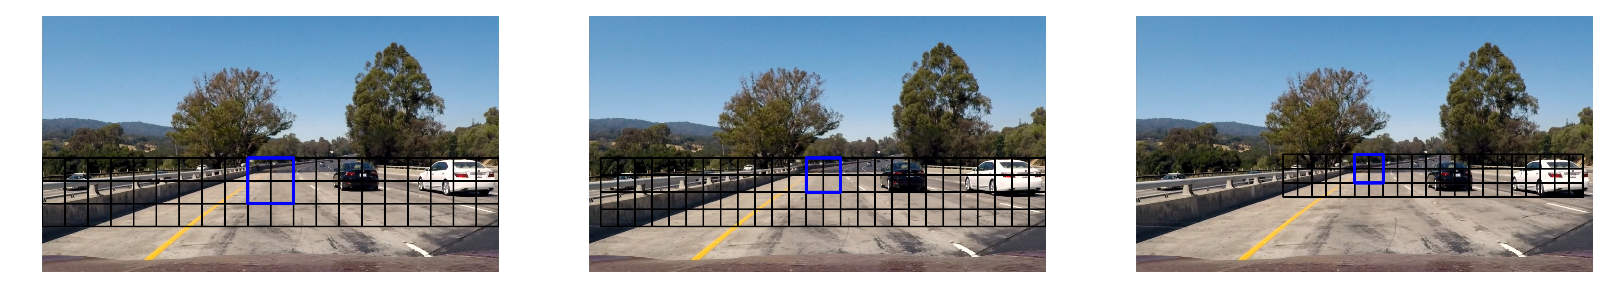

In [43]:
# defining parameters of sliding windows
# I use 3 sliding windows with different sizes, and different positions

image = mpimg.imread('test_images/test1.jpg')
window_img = np.copy(image)

window1 = {'x_limits': [None, None],
           'y_limits': [400, 640],
           'window_size': [128, 128],
           'overlap': [.5, .5]}

window2 = {'x_limits': [32, None],
           'y_limits': [400, 600],
           'window_size': [96, 96],
           'overlap': [.5, .5]}

window3 = {'x_limits': [412, 1280],
           'y_limits': [390, 540],
           'window_size': [80, 80],
           'overlap': [.5, .5]}

windows_list = [slide_window(image, x_start_stop=window['x_limits'], y_start_stop=window['y_limits'], 
                    xy_window=window['window_size'], xy_overlap=window['overlap']) for window in [window1, window2, window3]]

sliding_windows = [draw_boxes(np.copy(image), windows, color=(0, 0, 0), thick=4) for windows in windows_list]

sliding_windows [0] = draw_boxes (sliding_windows [0], [windows_list[0][9]], color=(0, 0, 255), thick=8)
sliding_windows [1] = draw_boxes (sliding_windows [1], [windows_list[1][12]], color=(0, 0, 255), thick=8)
sliding_windows [2] = draw_boxes (sliding_windows [2], [windows_list[2][5]], color=(0, 0, 255), thick=8)

show_images_grid (sliding_windows, (3, 1), fig_size=(20, 14))

In [53]:
def find_hot_boxes (image):

    output_image = np.copy (image)
    all_hot_windows = []
    
    # iterate over previousely defined sliding windows
    for window in [window1, window2, window3]:

        windows = slide_window(
            output_image,
            x_start_stop=window['x_limits'],
            y_start_stop=window['y_limits'], 
            xy_window=window['window_size'],
            xy_overlap=window['overlap']
        )

        hot_windows = []

        for window in windows:
        # Get test window from image
            test_image = cv2.resize(image[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64), interpolation=cv2.INTER_AREA)  
            features = extract_features(test_image, color_space=color_space, 
                                spatial_size=spatial_size, hist_bins=hist_bins, 
                                orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, 
                                hog_channel=hog_channel, extract_spatial=extract_spatial, 
                                extract_hist=extract_hist, extract_hog=extract_hog)

            test_features = X_scaler.transform(np.array(features).reshape(1, -1))

            prediction = svc.predict(test_features)

            if prediction == 1:
                hot_windows.append(window)                   

            all_hot_windows.extend (hot_windows)

        output_image = draw_boxes(output_image, hot_windows, color=(0, 0, 1), thick=4)

    return all_hot_windows, output_image
        
def get_heat_map(image, bbox_list):

    heatmap = np.zeros_like(image[:,:,0]).astype(np.float)

    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    
    # Return updated heatmap
    return heatmap

# Taken from helper video

class AverageHotBox ():
    def __init__ (self, box):
        self.avg_box = [list(p) for p in box]
        self.detected_count = 1
        self.boxes = [box]
    
    def get_strength (self):
        """Returns number of joined boxes"""
        return self.detected_count
    
    def get_box (self):
        """Uses joined boxes information to compute
        this average box representation as hot box.
        This box has average center of all boxes and have
        size of 2 standard deviation by x and y coordinates of its points
        """
        if len(self.boxes) > 1:
            center = np.average (np.average (self.boxes, axis=1), axis=0).astype(np.int32).tolist()

            # getting all x and y coordinates of
            # all corners of joined boxes separately
            xs = np.array(self.boxes) [:,:,0]
            ys = np.array(self.boxes) [:,:,1]

            half_width = int(np.std (xs))
            half_height = int(np.std (ys))
            return (
                (
                    center[0] - half_width,
                    center[1] - half_height
                ), (
                    center[0] + half_width,
                    center[1] + half_height
                ))
        else:
            return self.boxes [0]
    
    def is_close (self, box):
        """Check wether specified box is close enough for joining
        to be close need to overlap by 30% of area of this box or the average box
        """
        
        # Thank you, davin
        # http://math.stackexchange.com/questions/99565/simplest-way-to-calculate-the-intersect-area-of-two-rectangles
        x11 = self.avg_box [0][0]
        y11 = self.avg_box [0][1]
        x12 = self.avg_box [1][0]
        y12 = self.avg_box [1][1]
        x21 = box [0][0]
        y21 = box [0][1]
        x22 = box [1][0]
        y22 = box [1][1]
            
        x_overlap = max(0, min(x12,x22) - max(x11,x21))
        y_overlap = max(0, min(y12,y22) - max(y11,y21))

        area1 = (x12 - x11) * (y12 - y11)
        area2 = (x22 - x21) * (y22 - y21)
        intersection = x_overlap * y_overlap;
        
        if (
            intersection >= 0.3 * area1 or
            intersection >= 0.3 * area2
        ):
            return True
        else:
            return False
    
    def join (self, boxes):
        """Join in all boxes from list of given boxes,
        removes joined boxes from input list of boxes
        """
        
        joined = False
        
        for b in boxes:
            if self.is_close (b):
                boxes.remove (b)
                self.boxes.append (b)
                self.detected_count += 1
                
                self.avg_box [0][0] = min (self.avg_box [0][0], b [0][0])
                self.avg_box [0][1] = min (self.avg_box [0][1], b [0][1])
                self.avg_box [1][0] = max (self.avg_box [1][0], b [1][0])
                self.avg_box [1][1] = max (self.avg_box [1][1], b [1][1])
                
                joined = True

        return joined

def calc_average_boxes (hot_boxes, strength):
    """Compute average boxes from specified hot boxes and returns
    average boxes with equals or higher strength
    """
    avg_boxes = []
    while len(hot_boxes) > 0:
        b = hot_boxes.pop (0)
        hb = AverageHotBox (b)
        while hb.join (hot_boxes):
            pass
        avg_boxes.append (hb)
    
    boxes = []
    for ab in avg_boxes:
        if ab.get_strength () >= strength:
            boxes.append (ab.get_box ())
    return boxes


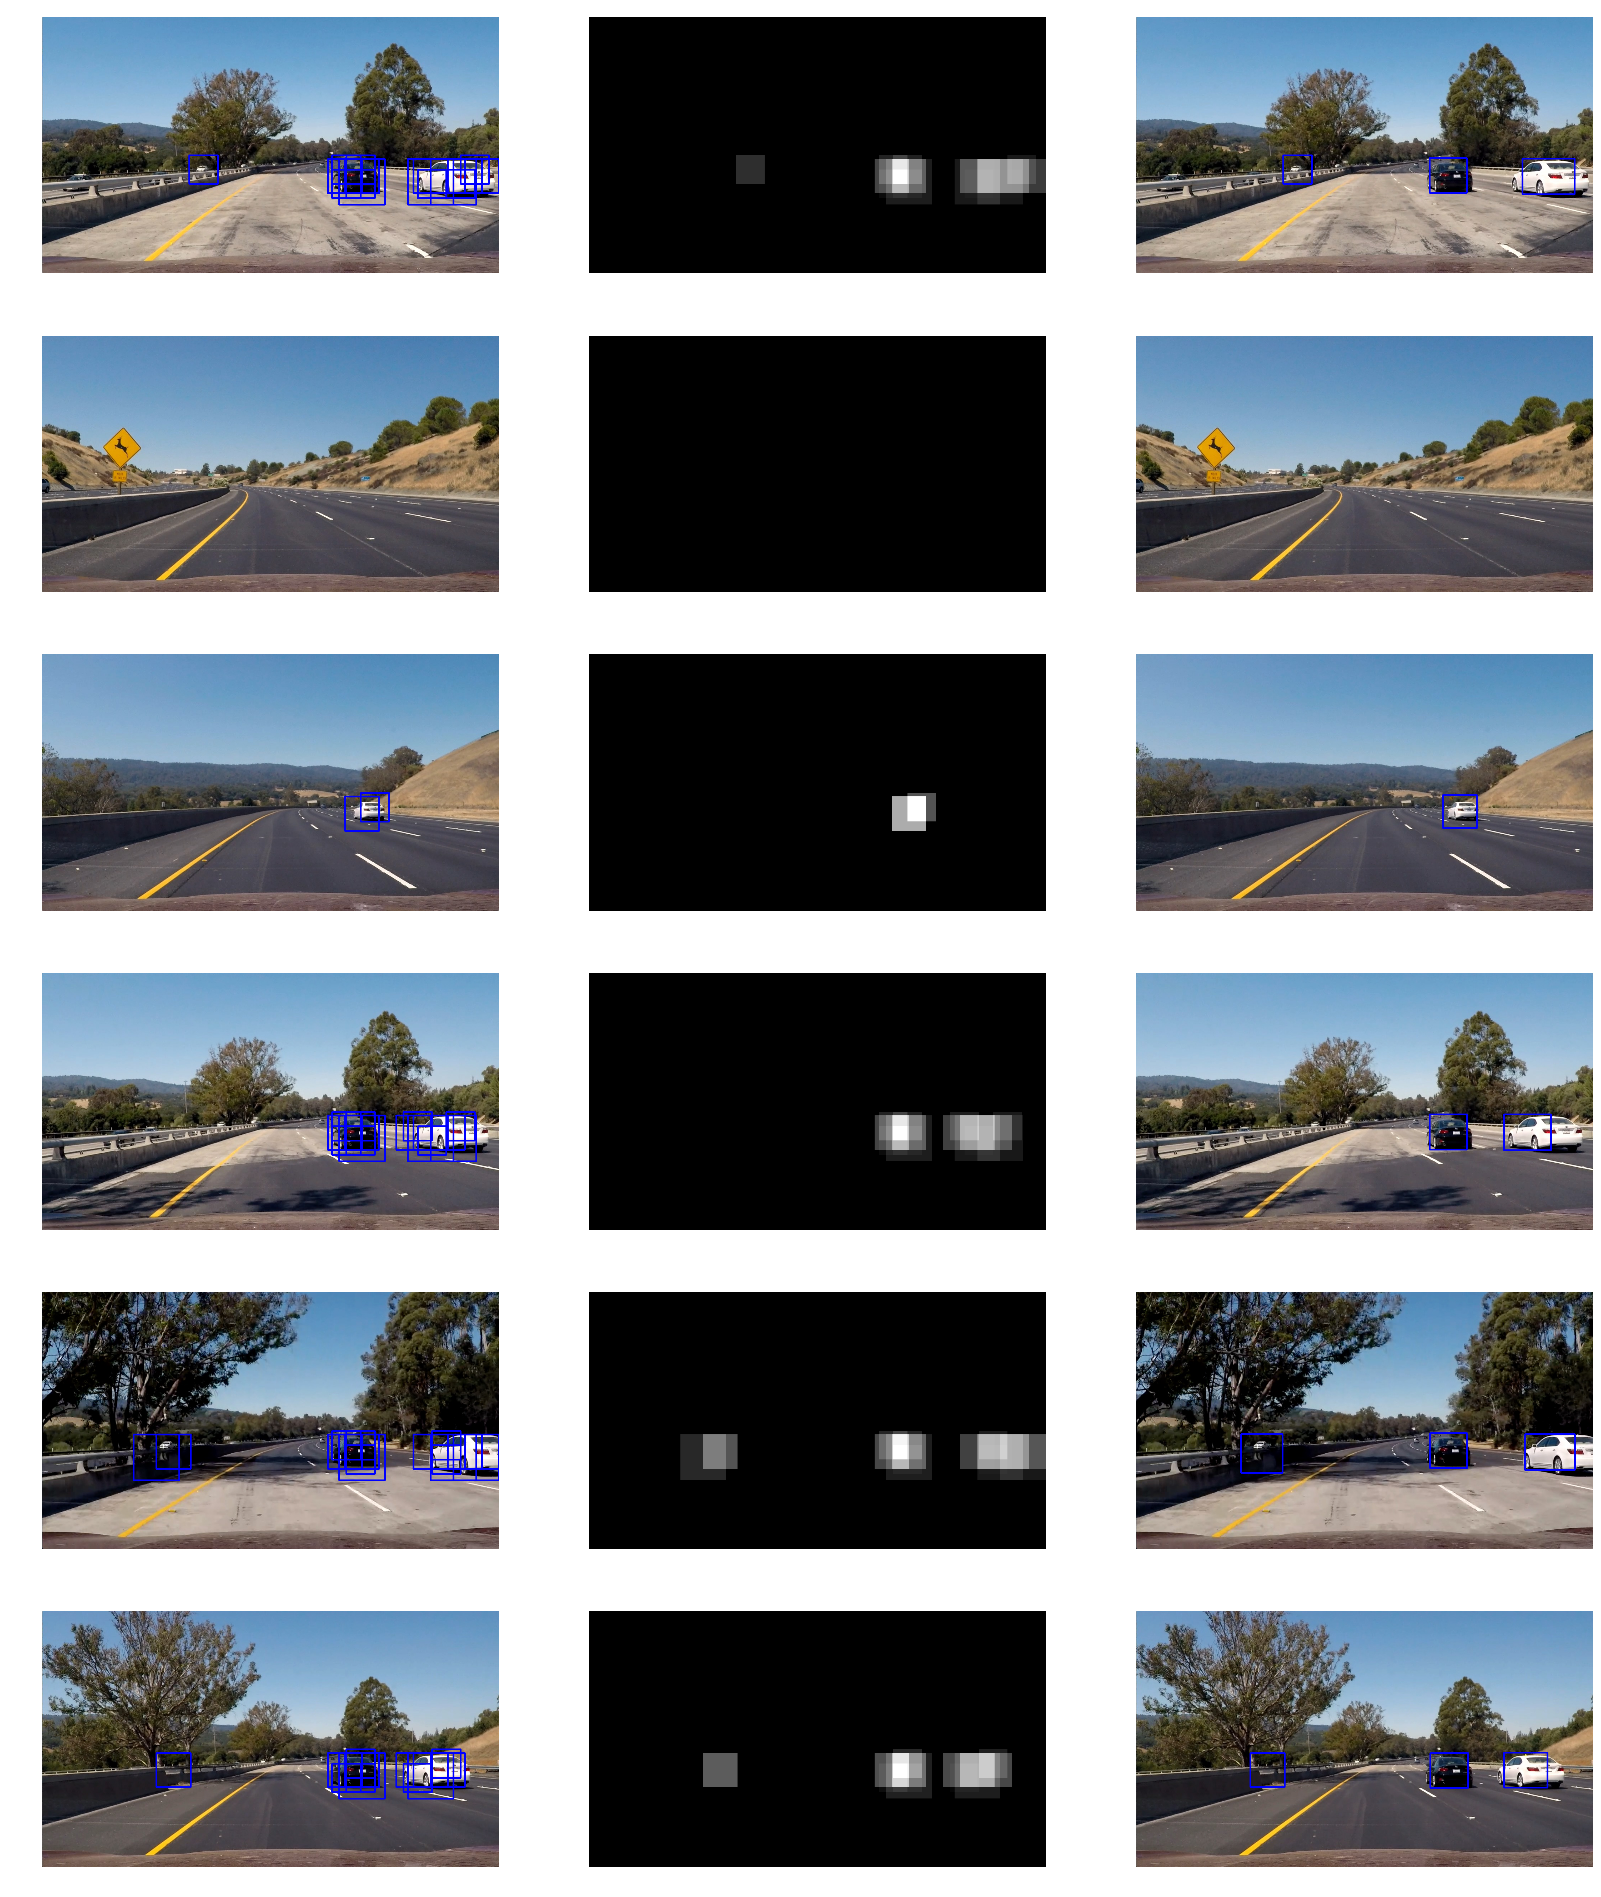

In [55]:
# algorithm demonstration on test images

test_images = []
test_images_titles = []

for impath in glob.glob('test_images/test*.jpg'):
    image_orig = mpimg.imread(impath)
    
    # Uncomment the following line if you extracted training
    # data from .png images (scaled 0 to 1 by mpimg) and the
    # image you are searching is a .jpg (scaled 0 to 255)
    image = image_orig.astype(np.float32)/255

    # hot boxes
    hot_boxes, image_with_hot_boxes = find_hot_boxes (image)
    # heat map
    heat_map = get_heat_map (image, hot_boxes)
    
    # average boxes
    avg_boxes = calc_average_boxes (hot_boxes, 2)
    image_with_boxes = draw_boxes(image, avg_boxes, color=(0, 0, 1), thick=4)
    
    test_images.append (image_with_hot_boxes)
    test_images.append (heat_map)
    test_images.append (image_with_boxes)
    
    test_images_titles.extend (['', '', ''])
    
test_images_titles [0] = 'hot boxes'
test_images_titles [1] = 'heat map'
test_images_titles [2] = 'average boxes'

show_images_grid (test_images, (3, 6), fig_size=(20, 24), titles=test_images_titles)

In [58]:
# These are for keeping data about hot boxes

class LastHotBoxesQueue():
    """Class for accumulation of hot boxes from last 10 frames
    """
    def __init__ (self):
        self.queue_max_len = 10 # number items to store
        self.last_boxes = []

    def put_hot_boxes(self, boxes):
        """Put frame hot boxes
        """
        if (len(self.last_boxes) > self.queue_max_len):
            tmp = self.last_boxes.pop(0)
        
        self.last_boxes.append (boxes)
        
    def hot_boxes(self):
        """Get last 10 frames hot boxes
        """
        b = []
        for boxes in self.last_boxes:
            b.extend (boxes)
        return b

last_hot_boxes = LastHotBoxesQueue()
    
def process_image(image_orig):
    
    image_orig = np.copy (image_orig)
    image = image_orig.astype(np.float32)/255
    
    # accumulating hot boxes over 10 last frames
    hot_boxes, image_with_hot_boxes = find_hot_boxes(image)
    last_hot_boxes.put_hot_boxes(hot_boxes)
    hot_boxes = last_hot_boxes.hot_boxes()
    
    # calculating average boxes and use strong ones
    # need to tune strength on particular classifer
    avg_boxes = calc_average_boxes (hot_boxes, 20)
    image_with_boxes = draw_boxes(image, avg_boxes, color=(0, 0, 1), thick=4)

    return image_with_boxes * 255

In [59]:
from moviepy.editor import VideoFileClip
# import imageio
# imageio.plugins.ffmpeg.download()

def process_video (input_path, output_path):
    clip = VideoFileClip (input_path)
    
    # uncomment to operate on individual frames
#     image = clip.get_frame(8./30)
#     r = process_image(image)
#     plt_show (r/255)

    result = clip.fl_image (process_image)
    %time result.write_videofile (output_path)


process_video ('project_video.mp4', 'project_video_result.mp4')


[MoviePy] >>>> Building video project_video_result.mp4
[MoviePy] Writing audio in project_video_resultTEMP_MPY_wvf_snd.mp3


100%|██████████| 1112/1112 [00:00<00:00, 2108.82it/s]

[MoviePy] Done.
[MoviePy] Writing video project_video_result.mp4



100%|█████████▉| 1260/1261 [10:24<00:00,  2.11it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_result.mp4 

CPU times: user 9min 49s, sys: 46.7 s, total: 10min 35s
Wall time: 10min 26s
